## Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/NSDE/functions/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from get_data import load_data
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
df = load_data('MB.MI')

[*********************100%%**********************]  1 of 1 completed


In [4]:
split = int(len(df)*0.9)
train = df['log_close'][:split]
test = df['log_close'][split:]

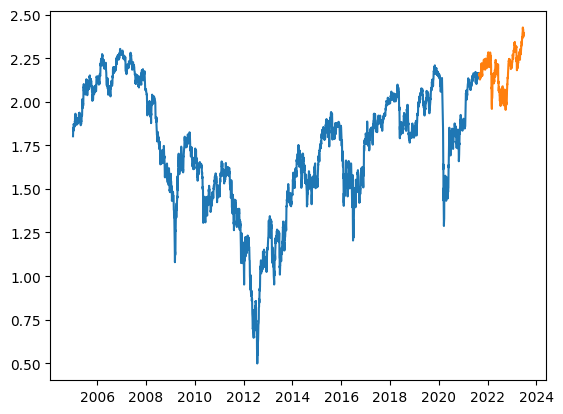

In [5]:
plt.plot(train)
plt.plot(test)

In [6]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return torch.tensor(dataX).to(torch.float32), torch.tensor(dataY).to(torch.float32)

In [7]:
trainX, trainY = create_dataset(train, 1)
testX, testY = create_dataset(test, 1)



## batching

In [8]:
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [9]:
train_df = TensorDataset(trainX, trainY)
test_df = TensorDataset(testX, testY)

In [10]:
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(train_df,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_df,
                             batch_size=1,
                             num_workers=NUM_WORKERS)

Creating DataLoader's with batch size 128 and 2 workers.


## Creating Model

In [11]:
class Simple_NSDE(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Linear(1,64),
            nn.Linear(64,2),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        batch_size = x.shape[0]

        # Generate random noise (Wiener process) for each sample in the batch
        dW = torch.randn(batch_size)

        # Extract drift and diffusion terms from the neural network
        network_output = self.layer_1(x)
        drift = network_output[:, 0]
        diff = network_output[:, 1]

        # Compute diffusion using the exponential transformation
        diffusion = torch.exp(0.5 * diff)

        # Compute the next state or price using the NSDE formula
        Y = x.squeeze() + drift + diffusion * dW

        return Y

In [12]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss = 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()


    # Adjust metrics to get average loss per batch
    train_loss = train_loss / len(dataloader)
    return train_loss

In [13]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss = 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

    # Adjust metrics to get average loss  per batch
    test_loss = test_loss / len(dataloader)
    return test_loss

In [14]:
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
          train_loader: torch.utils.data.DataLoader,
          test_loader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.MSELoss(),
          epochs: int = 60):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "test_loss": [],
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss= train_step(model=model,
                               dataloader=train_loader,
                               loss_fn=loss_fn,
                               optimizer=optimizer)
        test_loss = test_step(model=model,
                              dataloader=test_loader,
                              loss_fn=loss_fn)

        # 4. Print out what's happening
        if (epoch+1) % 10 == 0:
          print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f} | "
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    # 6. Return the filled results at the end of the epochs
    return results

In [15]:
# Set number of epochs
NUM_EPOCHS = 60

# Recreate an instance of TinyVGG
model_0 = Simple_NSDE()

# Setup loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_loader=train_dataloader,
                        test_loader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.9576 | test_loss: 1.0233 | 
Epoch: 20 | train_loss: 1.0420 | test_loss: 1.0424 | 
Epoch: 30 | train_loss: 0.9897 | test_loss: 1.0517 | 
Epoch: 40 | train_loss: 0.9860 | test_loss: 0.9144 | 
Epoch: 50 | train_loss: 1.0040 | test_loss: 1.0887 | 
Epoch: 60 | train_loss: 1.0039 | test_loss: 0.8639 | 
Total training time: 85.520 seconds


In [16]:
def plot_loss_curves(results: dict[str, list[float]]):

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()


In [17]:
def make_pred(model, test_loader, ytest):
    predictions = []
    import torch.nn.functional as F
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(test_loader):
            pred = model(X)
            predictions.append(pred)

    predictions = torch.cat(predictions)  # Concatenate predictions from all batches
    mse = F.mse_loss(predictions, ytest)

    plt.plot(predictions, label='predicted')
    plt.plot(ytest, label='test')
    plt.legend()
    plt.title(f'MSE: {mse.item():.4f}')  # Display the calculated MSE in the plot title
    plt.show()
    return predictions


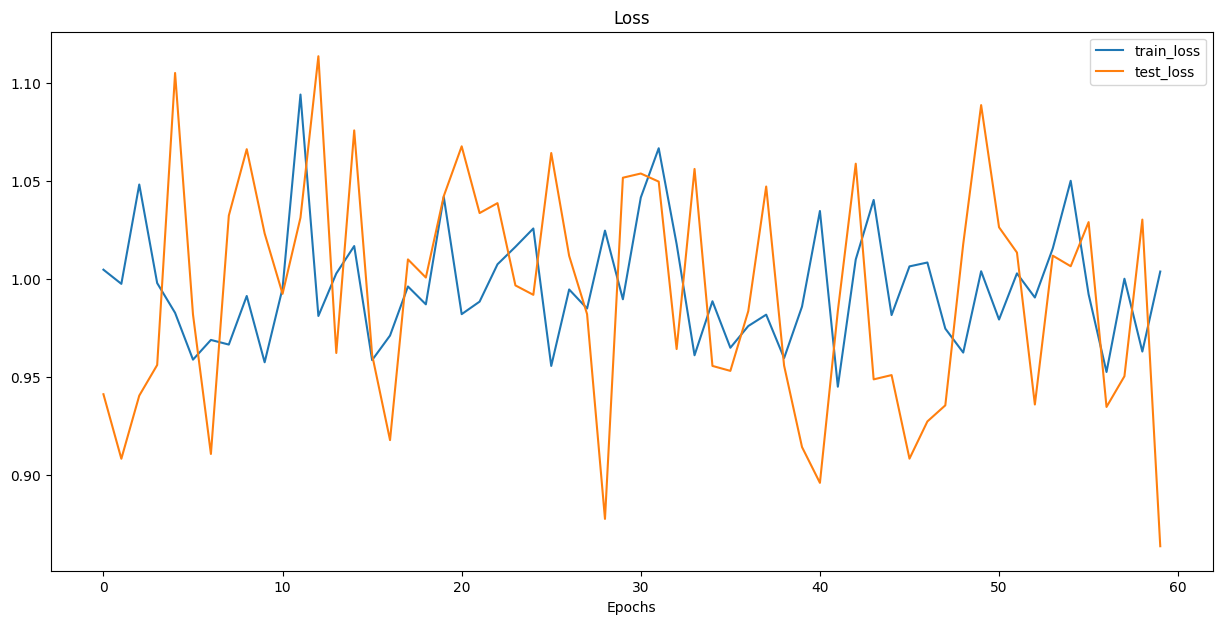

In [18]:
plot_loss_curves(model_0_results)

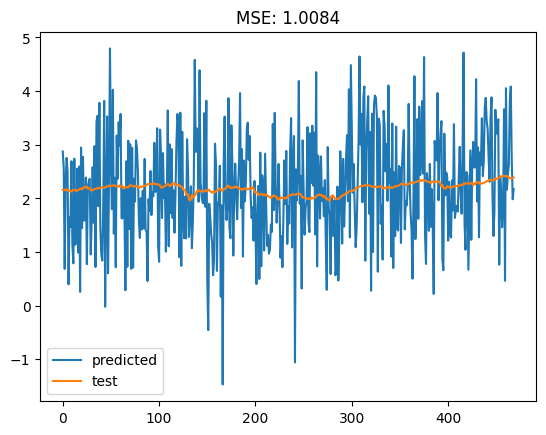

In [19]:
a = make_pred(model_0,test_dataloader,testY)

# Model 1

In [20]:
class NSDE1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Linear(1,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,2),
        )

    def forward(self, x: torch.Tensor):
        batch_size = x.shape[0]

        dW = torch.randn(batch_size)

        network_output = self.layer_1(x)
        drift = network_output[:, 0]
        diff = network_output[:, 1]
        diffusion = torch.exp(0.5 * diff)

        Y = x.squeeze() + drift + diffusion * dW

        return Y

In [21]:
# Set number of epochs
model_1 = NSDE1()
NUM_EPOCHS = 50
# Setup loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_loader=train_dataloader,
                        test_loader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.0007 | test_loss: 0.0004 | 
Epoch: 20 | train_loss: 0.0008 | test_loss: 0.0003 | 
Epoch: 30 | train_loss: 0.0006 | test_loss: 0.0009 | 
Epoch: 40 | train_loss: 0.0006 | test_loss: 0.0003 | 
Epoch: 50 | train_loss: 0.0006 | test_loss: 0.0003 | 
Total training time: 73.760 seconds


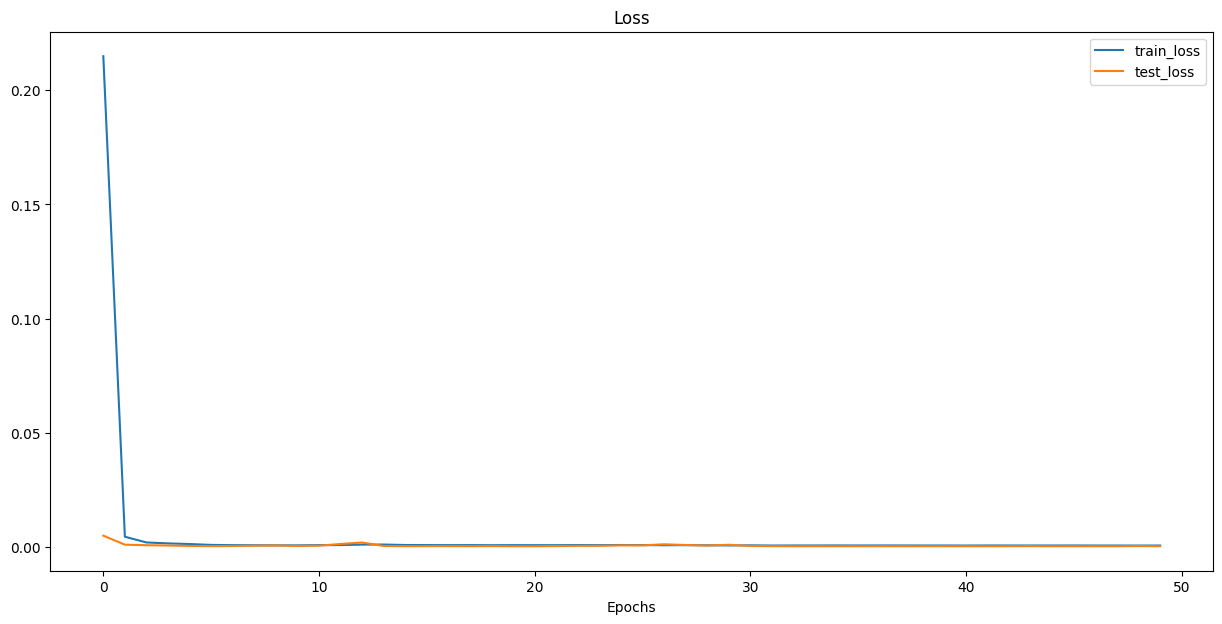

In [22]:
plot_loss_curves(model_1_results)

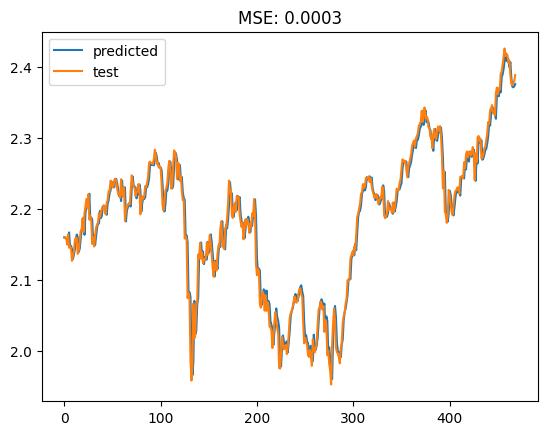

In [23]:
a= make_pred(model_1,test_dataloader,testY)

# Model 2

In [24]:
class NSDE2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Linear(1,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,2),
        )

    def forward(self, x: torch.Tensor):
        batch_size = x.shape[0]

        dW = torch.randn(batch_size)

        network_output = self.layer_1(x)
        drift = network_output[:, 0]
        diff = network_output[:, 1]
        diffusion = torch.exp(0.5 * diff)

        Y = x.squeeze() + drift + diffusion * dW

        return Y


In [25]:
# Set number of epochs
model_2 = NSDE2()
NUM_EPOCHS = 50
# Setup loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.01)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_2
model_2_results = train(model=model_2,
                        train_loader=train_dataloader,
                        test_loader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.0006 | test_loss: 0.0004 | 
Epoch: 20 | train_loss: 0.0006 | test_loss: 0.0005 | 
Epoch: 30 | train_loss: 0.0009 | test_loss: 0.0015 | 
Epoch: 40 | train_loss: 0.0009 | test_loss: 0.0003 | 
Epoch: 50 | train_loss: 0.0005 | test_loss: 0.0004 | 
Total training time: 76.150 seconds


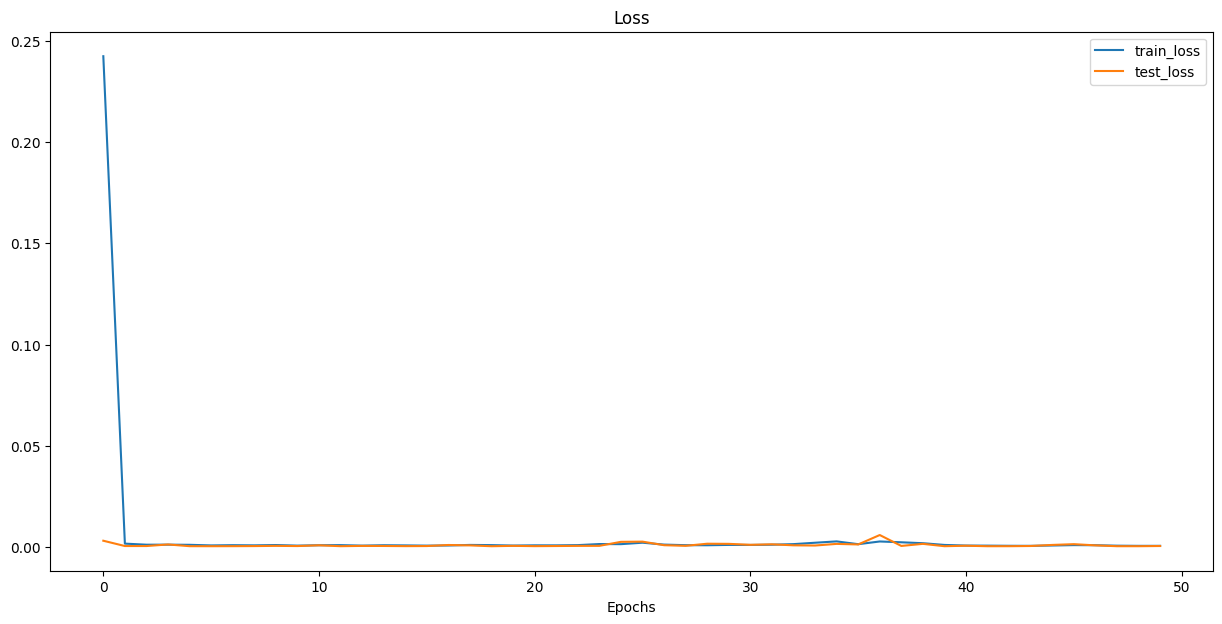

In [26]:
plot_loss_curves(model_2_results)

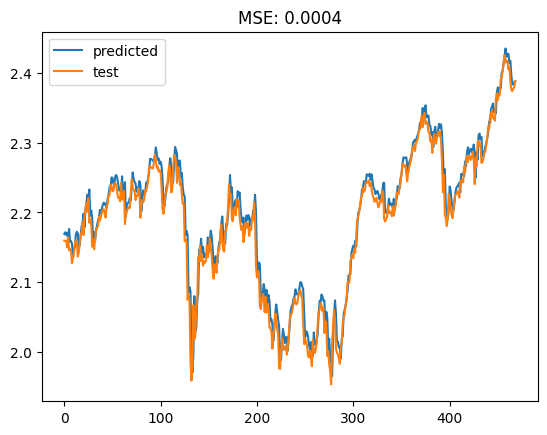

In [27]:
a= make_pred(model_2,test_dataloader,testY)

## Model 3



In [28]:
class NSDE3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Linear(1,32),
            nn.ReLU(),
            nn.Linear(32,32),
            nn.ReLU(),
            nn.Linear(32,2),
        )

    def forward(self, x: torch.Tensor):
        batch_size = x.shape[0]

        dW = torch.randn(batch_size)

        network_output = self.layer_1(x)
        drift = network_output[:, 0]
        diff = network_output[:, 1]
        diffusion = torch.exp(0.5 * diff)

        Y = x.squeeze() + drift + diffusion * dW

        return Y


In [29]:
# Set number of epochs
model_3 = NSDE3()
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.01)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_3
model_3_results = train(model=model_3,
                        train_loader=train_dataloader,
                        test_loader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.0014 | test_loss: 0.0040 | 
Epoch: 20 | train_loss: 0.0019 | test_loss: 0.0022 | 
Epoch: 30 | train_loss: 0.0010 | test_loss: 0.0009 | 
Epoch: 40 | train_loss: 0.0006 | test_loss: 0.0003 | 
Epoch: 50 | train_loss: 0.0007 | test_loss: 0.0003 | 
Total training time: 76.321 seconds


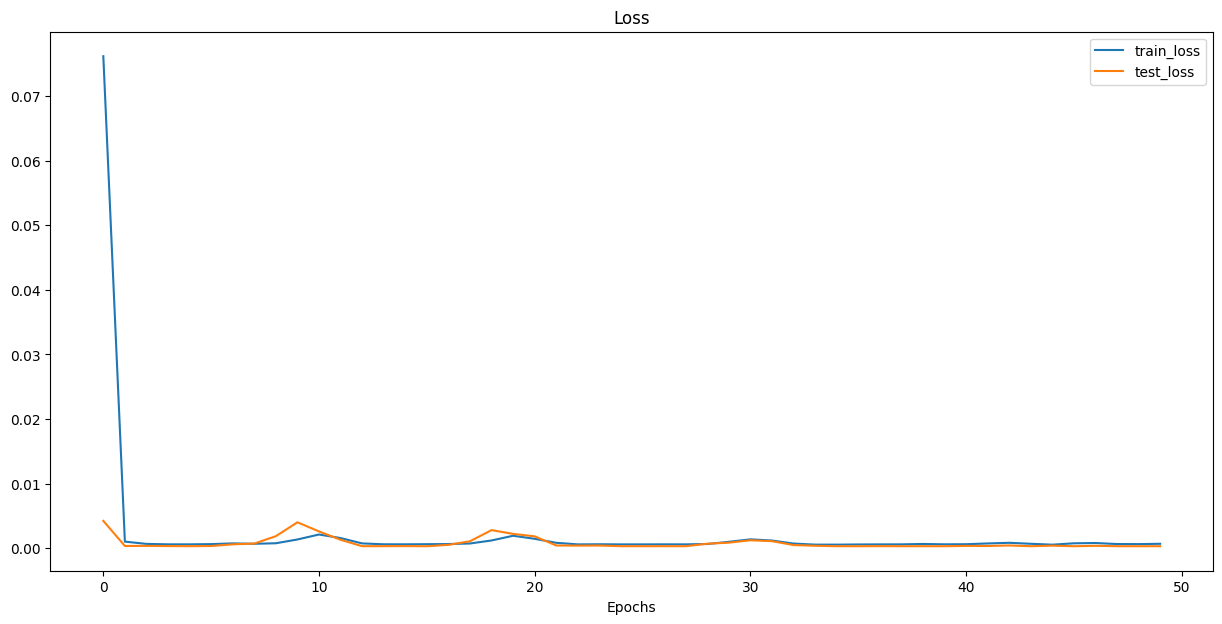

In [30]:
plot_loss_curves(model_3_results)

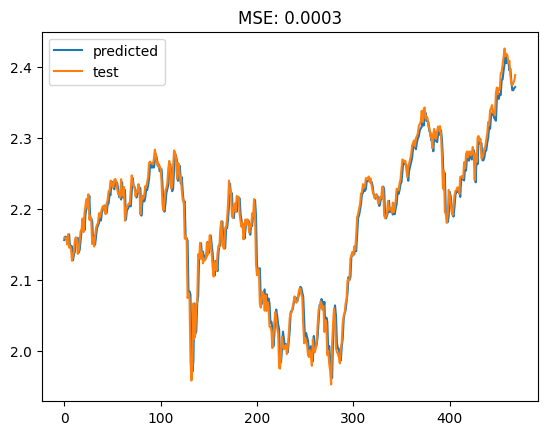

In [31]:
a= make_pred(model_3,test_dataloader,testY)

## Model 4



In [32]:
class NSDE4(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Linear(1,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,2),
        )

    def forward(self, x: torch.Tensor):
        batch_size = x.shape[0]

        dW = torch.randn(batch_size)

        network_output = self.layer_1(x)
        drift = network_output[:, 0]
        diff = network_output[:, 1]
        diffusion = torch.exp(0.5 * diff)

        Y = x.squeeze() + drift + diffusion * dW

        return Y


In [33]:
# Set number of epochs
model_4 = NSDE4()
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_4.parameters(), lr=0.01)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_3
model_4_results = train(model=model_4,
                        train_loader=train_dataloader,
                        test_loader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.0007 | test_loss: 0.0006 | 
Epoch: 20 | train_loss: 0.0006 | test_loss: 0.0005 | 
Epoch: 30 | train_loss: 0.0006 | test_loss: 0.0003 | 
Epoch: 40 | train_loss: 0.0007 | test_loss: 0.0005 | 
Epoch: 50 | train_loss: 0.0008 | test_loss: 0.0003 | 
Total training time: 77.009 seconds


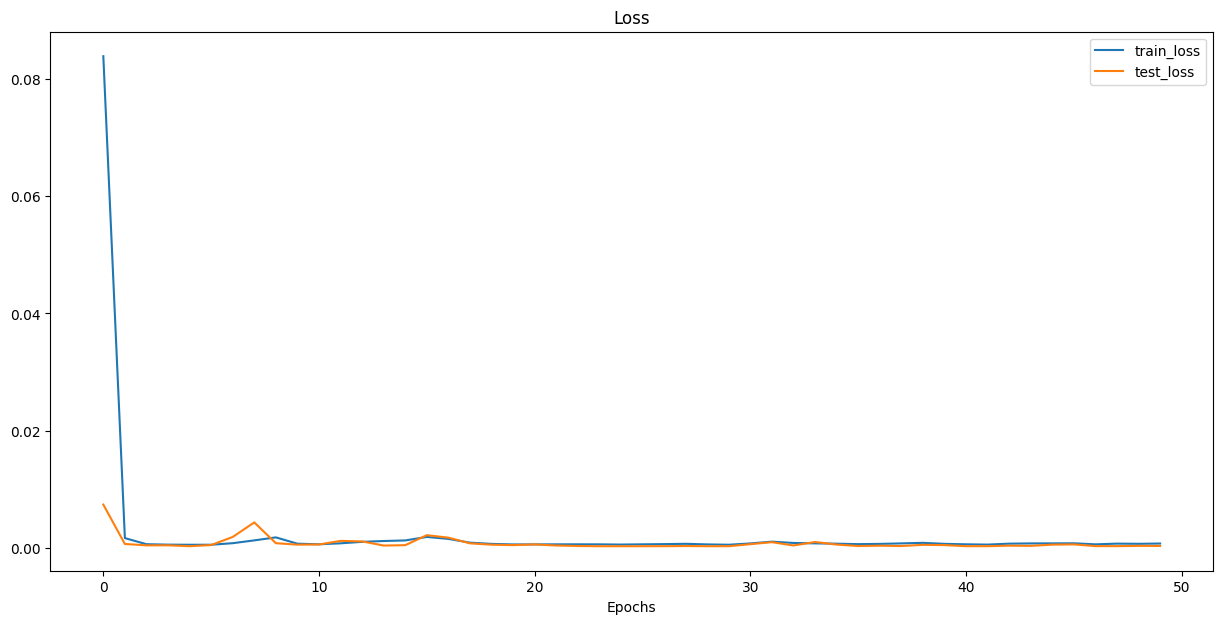

In [34]:
plot_loss_curves(model_4_results)

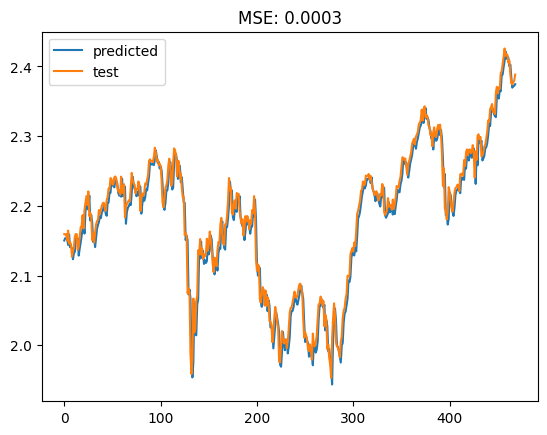

In [35]:
a= make_pred(model_4,test_dataloader,testY)

## Model 5



In [36]:
BATCH_SIZE = 500
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader1 = DataLoader(train_df,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)

test_dataloader1 = DataLoader(test_df,
                             batch_size=1,
                             num_workers=NUM_WORKERS)

Creating DataLoader's with batch size 500 and 2 workers.


In [37]:
class NSDE5(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Linear(1,64),
            nn.ReLU(),
            nn.Linear(64,2),
            nn.ReLU(),
           # nn.Linear(64,2),
        )

    def forward(self, x: torch.Tensor):
        batch_size = x.shape[0]

        dW = torch.randn(batch_size)

        network_output = self.layer_1(x)
        drift = network_output[:, 0]
        diff = network_output[:, 1]
        diffusion = torch.exp(0.5 * diff)

        Y = x.squeeze() + drift + diffusion * dW

        return Y


In [38]:
# Set number of epochs
model_5 = NSDE5()
NUM_EPOCHS = 40

# Setup loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_5.parameters(), lr=0.01)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_3
model_5_results = train(model=model_5,
                        train_loader=train_dataloader,
                        test_loader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 1.0367 | test_loss: 1.0348 | 
Epoch: 20 | train_loss: 0.9711 | test_loss: 0.9093 | 
Epoch: 30 | train_loss: 0.9835 | test_loss: 0.8897 | 
Epoch: 40 | train_loss: 0.9583 | test_loss: 0.9734 | 
Total training time: 60.121 seconds


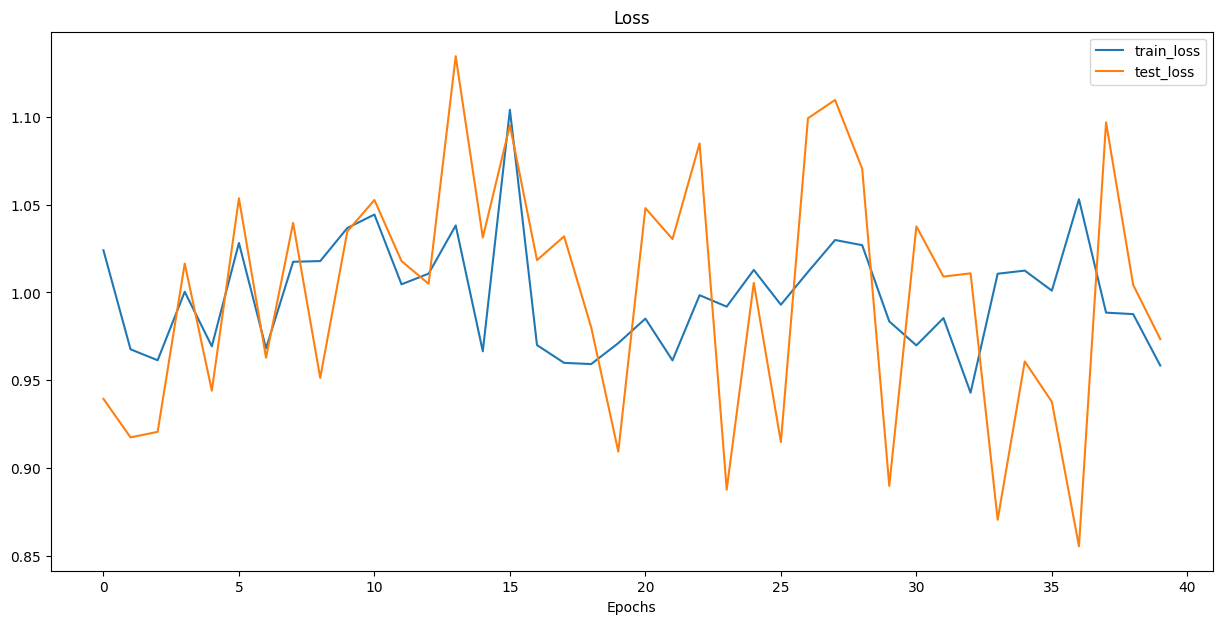

In [39]:
plot_loss_curves(model_5_results)

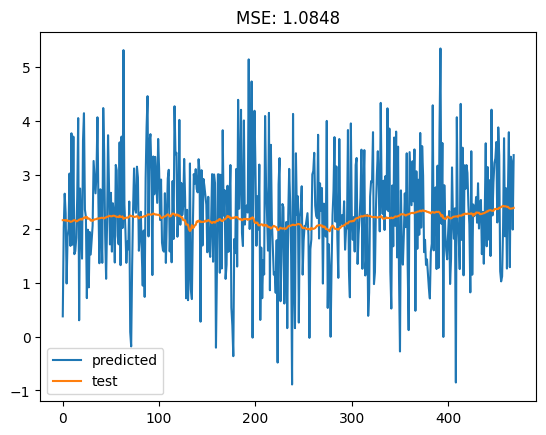

In [40]:
a= make_pred(model_5,test_dataloader,testY)

# Saving

In [43]:
from pathlib import Path
MODEL_PATH =  Path("/content/drive/MyDrive/NSDE/models")

# Create model save path
MODEL_NAME = "mediobanca.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to: /content/drive/MyDrive/NSDE/models/mediobanca.pth
